# Deep Learning - Exercise 2

This lecture is about introduction to using ANN for regression tasks.

We will use our models on [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset.

This dataset contains fule consumptions of several vehicles in miles per gallon. So, we need to predict the fuel efficiencies of various vehicles from the data that has been provided.

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_02.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_02.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


tf.version.VERSION

'2.11.0'

In [55]:
"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

"""
Computes SMAPE
"""
def symetric_mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2.0))) * 100

"""
Computes MAE, MSE, MAPE, SMAPE, R2
"""
def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    mae, mse, mape, smape, r2 = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), symetric_mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), r2_score(y_true=y_true, y_pred=y_pred)
    return pd.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'MAPE': mape, 'SMAPE': smape, 'R2': r2}], index=[0])

In [104]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [108]:
def show_history_loss(history):
    plt.figure()
    for key in history.history.keys():
        if 'loss' not in key:
            continue
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

## 🔎 Let's find answers to these quetions first! 🔎
1) How is regression different from the classification task?
2) How would you solve regression tasks? 
    - Describe briefly the pipeline, model and metrics used
2) How is ANN different from Linear regression model?

# Load the dataset first

## Dataset info
* Number of Instances: 398
* Number of Attributes: 9 including the class attribute

**Attribute Information:**

    1. mpg:           continuous
        * miles per gallon - higher the better
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

* Missing Attribute Values:  horsepower has 6 missing values

In [60]:
url = 'https://raw.githubusercontent.com/rasvob/VSB-FEI-Deep-Learning-Exercises/main/datasets/auto-mpg.csv'
rel_path = 'datasets/auto-mpg.csv'
df = pd.read_csv(url, na_values='?', sep=';')

In [61]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


## Check missing values

In [62]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

## 📊 Plot the data first 
* Which row/columns is the most important for us? Why? 📈
* Can you identify **categorical** features from these plot? How?
* Are the numeric ranges of the features the same? 
    * Can the difference among it make our task harder?
* What about other features? Is there any covariance/colinearity?

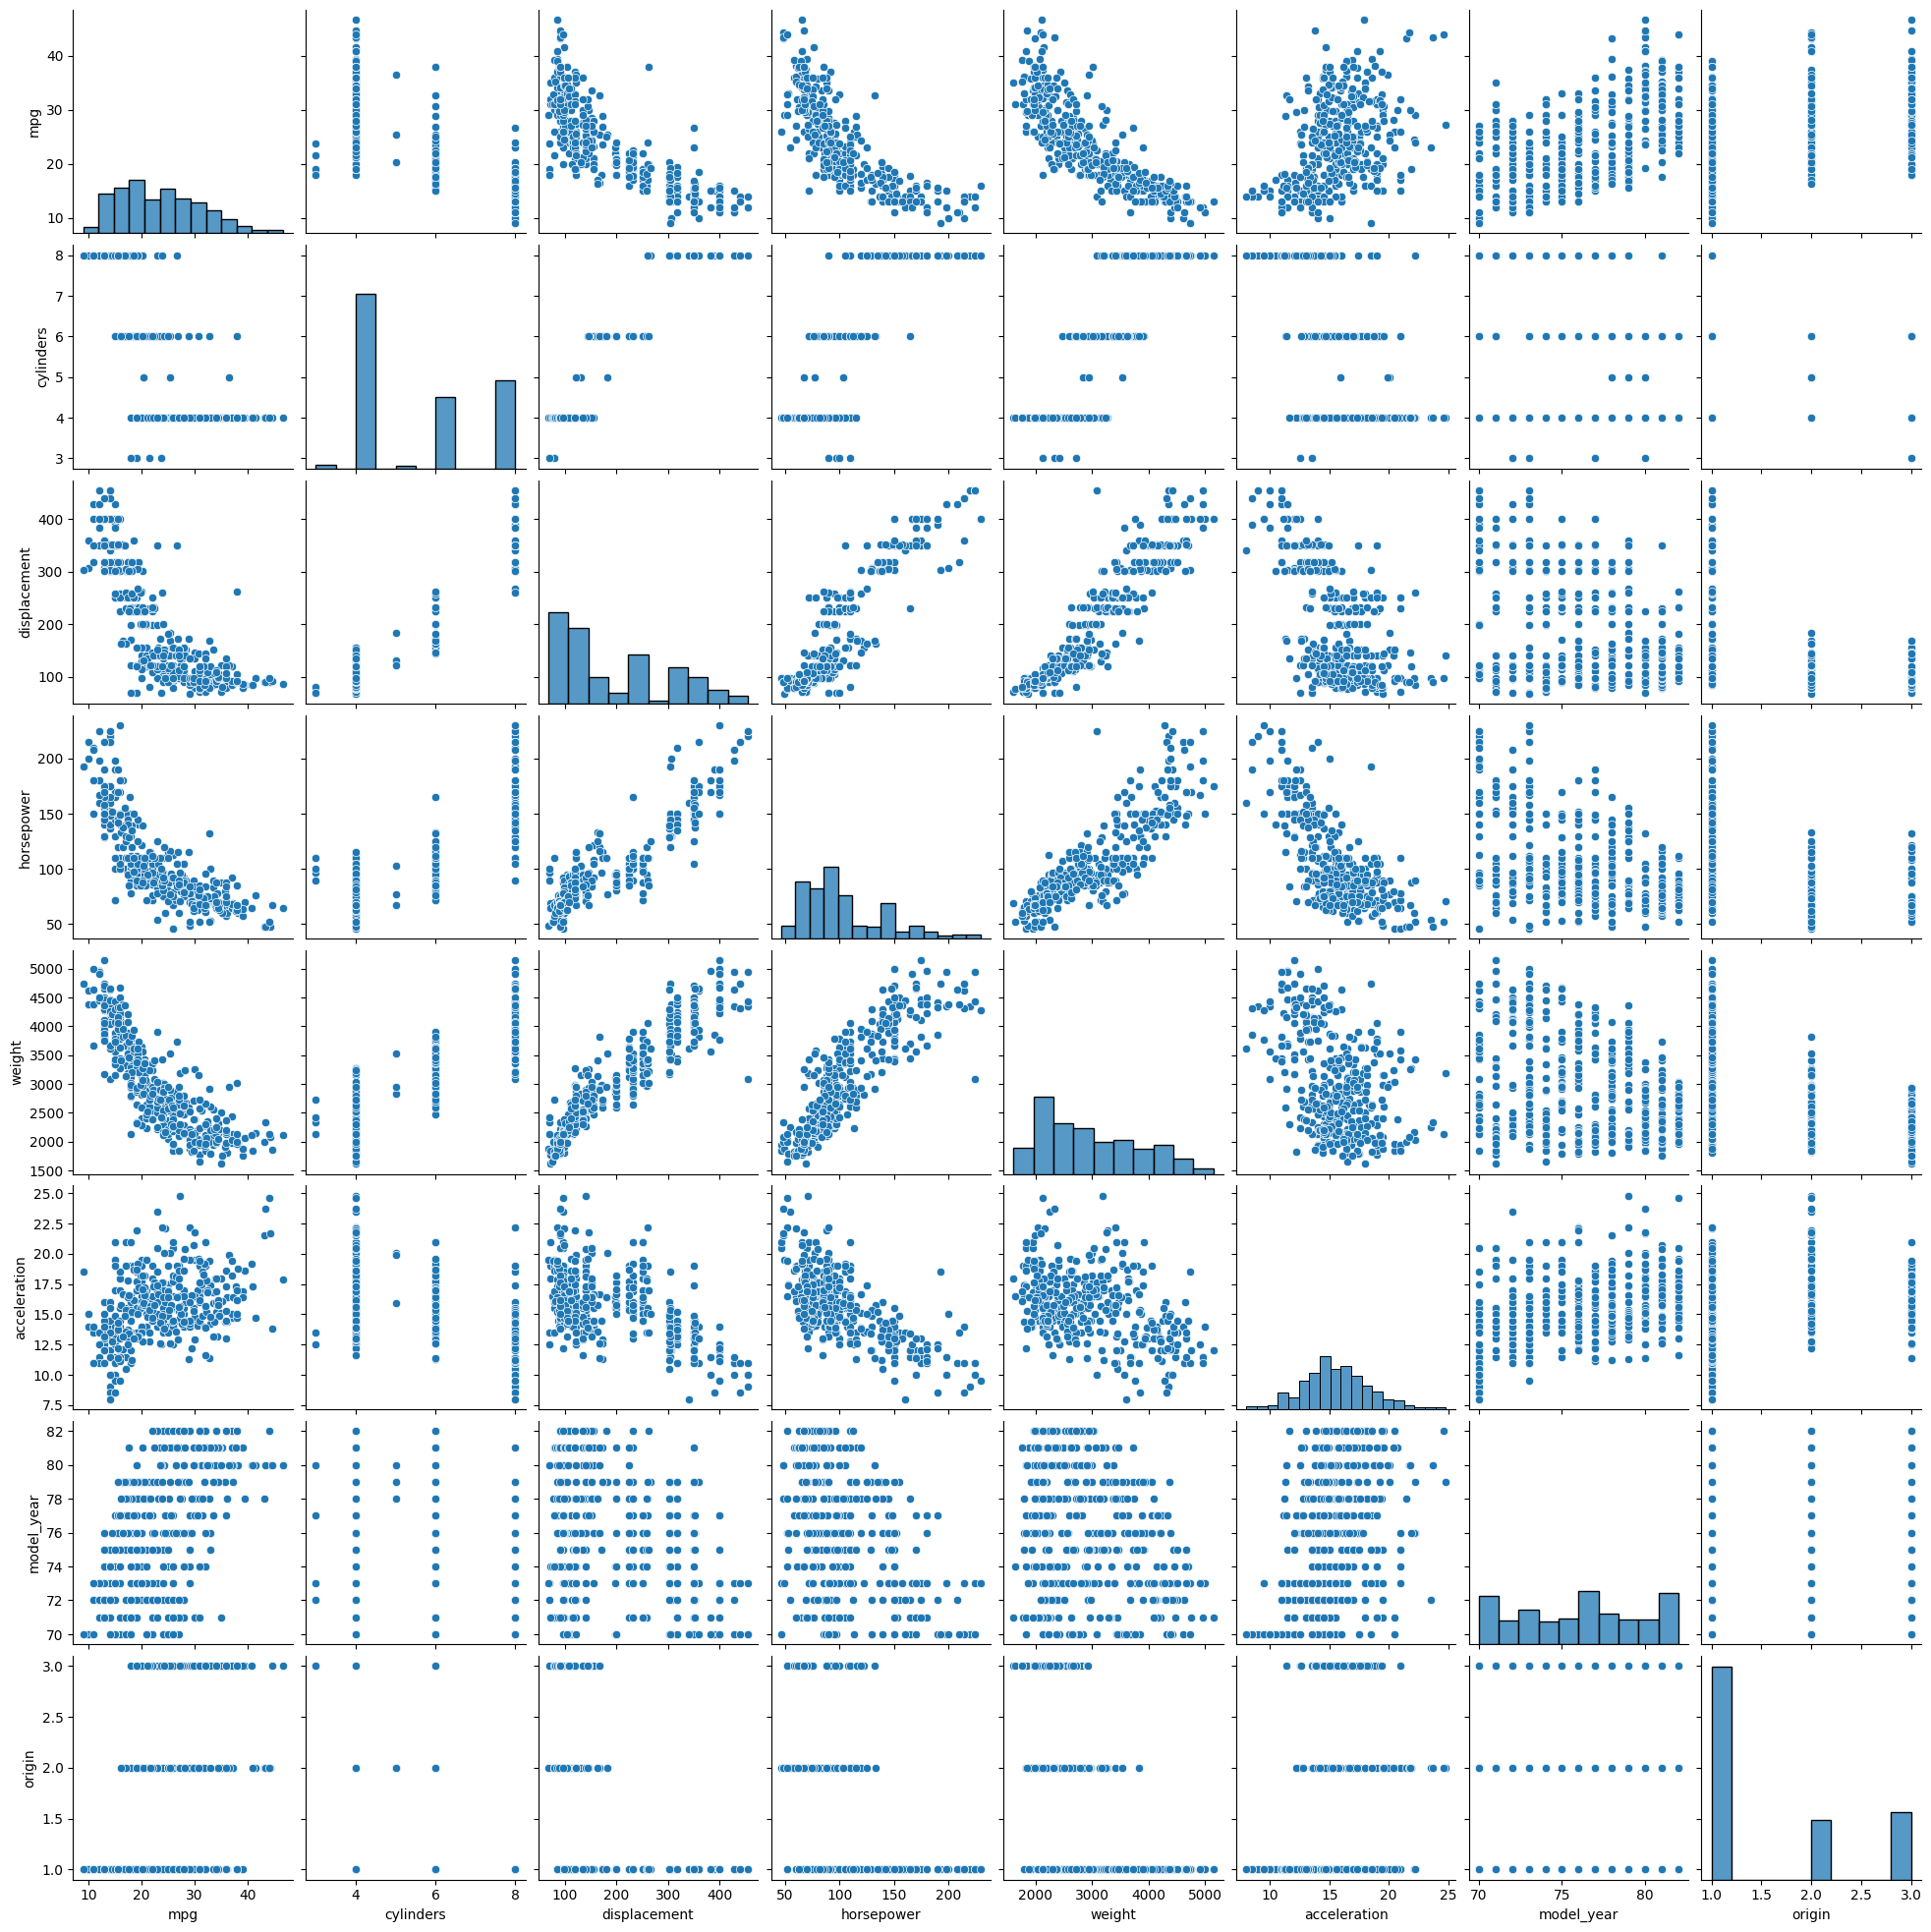

In [63]:
sns.pairplot(df)

## Do you see any colinearity in the data?
* Can it cause any issue? How to deal with it?

<Axes: >

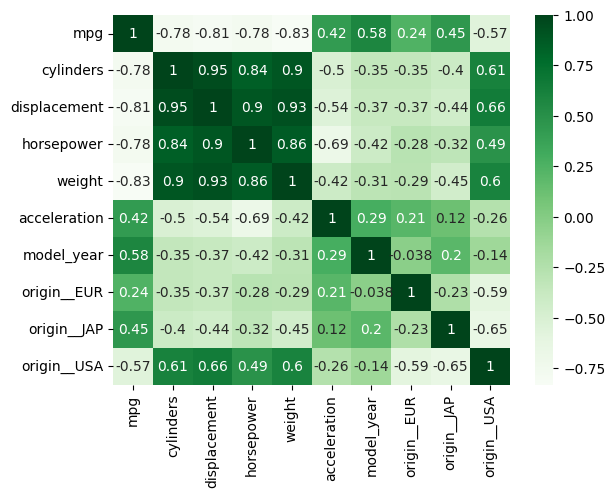

In [88]:
sns.heatmap(df.corr(), cmap='Greens', annot=True)

## We can plot the categorical data using boxplots
* Beware that the data are about cars from 80s, we won't see many 6 or 8 cylinder cars nowadays

<Axes: xlabel='cylinders', ylabel='mpg'>

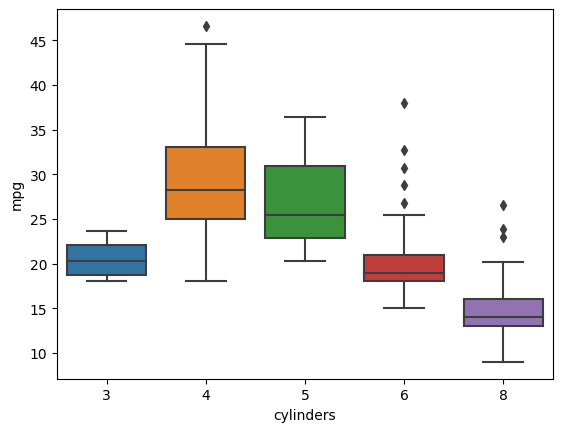

In [64]:
sns.boxplot(df, x='cylinders', y='mpg')

<Axes: xlabel='origin', ylabel='mpg'>

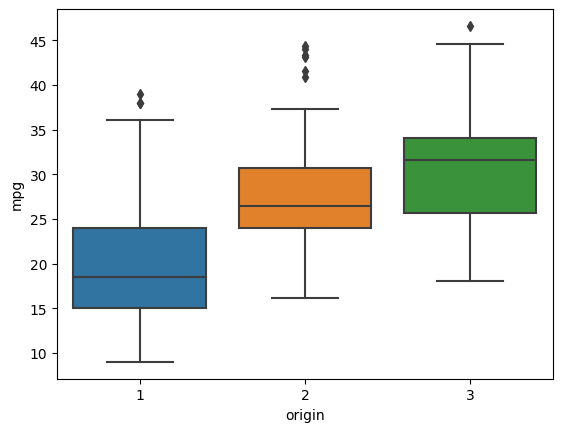

In [65]:
sns.boxplot(df, x='origin', y='mpg')

## 💡 There is no info about the *origin* feature = detective work incoming 🙂

### What do you think that the origin means based on the printed data?
* And what car origin is your favourite? 🙂

In [66]:
df.loc[df.origin == 1, 'car_name']

0      chevrolet chevelle malibu
1              buick skylark 320
2             plymouth satellite
3                  amc rebel sst
4                    ford torino
                 ...            
392             chevrolet camaro
393              ford mustang gl
395                dodge rampage
396                  ford ranger
397                   chevy s-10
Name: car_name, Length: 249, dtype: object

In [67]:
df.loc[df.origin == 2, 'car_name']

19     volkswagen 1131 deluxe sedan
20                      peugeot 504
21                      audi 100 ls
22                         saab 99e
23                         bmw 2002
                   ...             
354                     renault 18i
359       peugeot 505s turbo diesel
360                    volvo diesel
375             volkswagen rabbit l
394                       vw pickup
Name: car_name, Length: 70, dtype: object

In [68]:
df.loc[df.origin == 3, 'car_name']

14     toyota corona mark ii
18              datsun pl510
29              datsun pl510
31             toyota corona
53       toyota corolla 1200
               ...          
382           toyota corolla
383              honda civic
384       honda civic (auto)
385            datsun 310 gx
390         toyota celica gt
Name: car_name, Length: 79, dtype: object

## Okay, now we have the basic understanding of the data we can start to try some models
* We need to deal with the NA values first, as is it just a few rows, we will drop the data

In [69]:
df = df.loc[~df.horsepower.isna(), :].copy()

# Finishing touch is the categorical features encoding
* We will need to deal with *origin* and *car_name* features
    * Why is *origin* categorical? Isn't it numerical value already? What's the catch?

### car_name is problematic beacause we have quite a few brands so one-hot encoding would add too many columns
* We will drop the feature

In [70]:
df['car_name'].apply(lambda x: x.split(' ')[0]).value_counts()

ford             48
chevrolet        43
plymouth         31
dodge            28
amc              27
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
fiat              8
peugeot           8
audi              7
vw                6
chrysler          6
volvo             6
opel              4
saab              4
subaru            4
chevy             3
renault           3
maxda             2
cadillac          2
bmw               2
mercedes-benz     2
triumph           1
vokswagen         1
mercedes          1
hi                1
capri             1
chevroelt         1
toyouta           1
nissan            1
Name: car_name, dtype: int64

In [71]:
df = df.drop('car_name', axis=1)

In [73]:
df['origin'] = df['origin'].replace({1: 'USA', 2: 'EUR', 3: 'JAP'})

In [76]:
df = pd.get_dummies(df, columns=['origin'], prefix=['origin_'])

In [77]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin__EUR,origin__JAP,origin__USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


## Split the data into input and output part

In [78]:
X, y = df.drop('mpg', axis=1), df.mpg

In [80]:
X.shape, y.shape

((392, 9), (392,))

## Do the train/test in ratio 80:20

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [82]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((313, 9), (79, 9), (313,), (79,))

# Now we can create a baseline model now
* We will use traditional linear regression

![Meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_reg_01.jpg?raw=true)

## We will use just *horsepower* and *model_year* features because the high correlation values

In [124]:
alg = LinearRegression()
alg.fit(X_train.loc[:, ['horsepower', 'model_year']], y_train)
y_pred = alg.predict(X_test.loc[:, ['horsepower', 'model_year']])

## We can evaluate the model now

* We evaluated quality of classification models using its accuracy in the previous lectures.

* Regression tasks are not different - we have to evaluate model quality as well, but now we use different types of metrics
    * Most basic ones are MAE, RMSE
    * There are many more metrics - R2, MAPE, sMAPE etc
    
### 🔎 Can you define any of the metrics using mathematical formula?

* We have prepared the evaluation functions API for you so you can evaluate all the metrics in one function call

In [125]:
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

,MAE,MSE,MAPE,SMAPE,R2
0,3.941482,23.74165,19.133313,19.846932,0.581278


# Now we can create our first deep learning model and compare it to the baseline
* The ANN model can use more features as it is designed for bigger datasets and multicolinearity is not so big issue as in the LR case
* We will start with a raw data
* The evaluation step is the same

![Meme02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_reg_04.jpg?raw=true)

## 🔎 Why do we use *linear* activation in the output layer?

In [147]:
inp = keras.layers.Input(shape=(X_train.shape[1]))
                         
hidden_1 = keras.layers.Dense(128, activation='relu')(inp)
hidden_2 = keras.layers.Dense(32, activation='relu')(hidden_1)

out = keras.layers.Dense(1, activation='linear')(hidden_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),  
              optimizer=keras.optimizers.RMSprop(), 
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 9)]               0         
                                                                 
 dense_36 (Dense)            (None, 128)               1280      
                                                                 
 dense_37 (Dense)            (None, 32)                4128      
                                                                 
 dense_38 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [148]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 7ms/step - loss: 6173.1079 - mean_absolute_error: 31.7400 - mean_absolute_percentage_error: 148.0153 - val_loss: 3071.2766 - val_mean_absolute_error: 49.3183 - val_mean_absolute_percentage_error: 263.9962
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 1741.6196 - mean_absolute_error: 28.7357 - mean_absolute_percentage_error: 153.9259 - val_loss: 2080.6152 - val_mean_absolute_error: 40.1651 - val_mean_absolute_percentage_error: 216.1564
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 1404.0269 - mean_absolute_error: 28.7788 - mean_absolute_percentage_error: 146.3396 - val_loss: 1157.0903 - val_mean_absolute_error: 33.6548 - val_mean_absolute_percentage_error: 152.7230
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 1671.4733 - mean_absolute_error: 33.0031 - mean_absolute_percentage_error: 168.6838 - val_loss: 4790.0894 - val_mean_absolute_error: 68.5109 - v

## We can compute the same metrics as in the LR model case
* Is the model better?
    * Why?
* Why do we use .ravel() function?

In [149]:
model.load_weights("weights.best.hdf5")

y_pred = model.predict(X_test).ravel()

df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

3/3 [==============================] - 0s 965us/step


,MAE,MSE,MAPE,SMAPE,R2
0,3.019788,16.12906,14.169906,13.316301,0.715538


## It is very good practice to check the loss function values of train/validation data during the training and not only the metrics
* Do you see any issue with the val_loss?

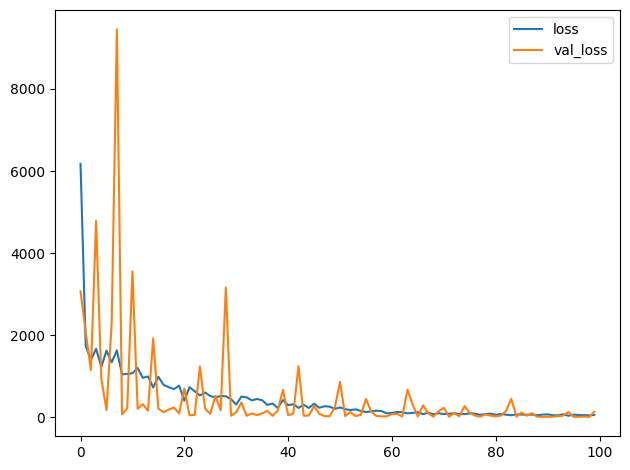

In [150]:
show_history_loss(history)

## The loss function plot show clear instability of learning
* This is a big issue in the regression tasks and it is pretty common one
* It is caused by the features magnitude differences


* **I recomment visiting https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter1_gradient-descent.html for more details about the matter**

# Defining terms for CNN

## Convolution
A convolution is defined as the integral of the product of the two functions after one is reversed and shifted. It is a mathmematical way how to analyze behavior of the functions and the relation between the functions.

In image processing, **kernel** or **convolution matrix** or **mask** is a small matrix. In general the convolution in image processing is defined as:

$$g(x, y) = \omega * f(x,y) = \sum_{s=-a}^{a}\sum_{t=-b}^{b}\omega(s,t)f(x-s, y-t)$$

where $g(x,y)$ is filtered image, $f(x,y)$ is original image, $\omega$ if the filter kernel. 

A kernel (also called a filter) is a smaller-sized matrix in comparison to the dimensions of the input image, that consists of real valued entries.


![Example of the Convolution](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/convolution_example.gif?raw=true "Conv eg")

### Example filters

|Name|Definition|
|----|:--------:|
|Identity| $\left[\begin{matrix}0&0&0\\0&1&0\\0&0&0\end{matrix}\right]$|
|Sobel vertical edge detection| $\left[\begin{matrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{matrix}\right]$|
|Sobel horizontal edge detection| $\left[\begin{matrix}+1&+2&+1\\0&0&0\\-1&-2&-1\end{matrix}\right]$|
|Edge detection| $\left[\begin{matrix}-1&-1&-1\\-1&8&-1\\-1&-1&-1\end{matrix}\right]$|
|Sharpen| $\left[\begin{matrix}0&-1&0\\-1&5&-1\\0&-1&0\end{matrix}\right]$|
|Uniform blur|$\frac{1}{9}\left[\begin{matrix}1&1&1\\1&1&1\\1&1&1\end{matrix}\right]$|
|Gaussian blur 3x3| $\frac{1}{16}\left[\begin{matrix}1&2&1\\2&4&2\\1&2&1\end{matrix}\right]$|


## Padding

One tricky issue when applying convolutional is losing pixels on the edges of our image. A straightforward solution to this problem is to add extra pixels around the boundary of our input image, which increases the effective size of the image.

![Padding example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/padding_example.png?raw=true)

## Practical example of convolution and padding without TF
* We will download the famous Lena image and try to use some filters ourselves first

#### 🤩 **Fun fact**: Have you seen the Lena image before? Do you know the story behind it? 🤩

Alexander Sawchuk estimates that it was in June or July of 1973 when he, then an assistant professor of electrical engineering at the USC Signal and Image Processing Institute (SIPI), along with a graduate student and the SIPI lab manager, was hurriedly searching the lab for a good image to scan for a colleague's conference paper. They had tired of their stock of usual test images, dull stuff dating back to television standards work in the early 1960s. They wanted something glossy to ensure good output dynamic range, and they wanted a human face. Just then, somebody happened to walk in with a recent issue of Playboy.

The engineers tore away the top third of the centerfold so they could wrap it around the drum of their Muirhead wirephoto scanner, which they had outfitted with analog-to-digital converters (one each for the red, green, and blue channels) and a Hewlett Packard 2100 minicomputer. The Muirhead had a fixed resolution of 100 lines per inch and the engineers wanted a 512 x 512 image, so they limited the scan to the top 5.12 inches of the picture, effectively cropping it at the subject's shoulders.

See more at [2001 paper IEEE Professional Communication Society](http://www.lenna.org/pcs_mirror/may_june01.pdf)

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

lena_img_url = 'https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/lena.png?raw=true'

response = requests.get(lena_img_url)
img = Image.open(BytesIO(response.content))

### Let's see the input image first

In [ ]:
plt.imshow(img)

## Now let's make it grayscale
* How many color channels did the original picture have? And how about grayscale?

In [ ]:
rgb = np.array(img)
img = rgb2gray(rgb)
img = img/255.0
img.shape

In [ ]:
plt.imshow(img, cmap='gray')

## Now we can try some of the filters above

In [ ]:
blur_mask = np.ones((3,3))/9.0
edge_mask = np.ones((3,3))*-1
edge_mask[1, 1] = 8
mask = np.array([
    [ 0,-1, 0],
    [-1, 4,-1],
    [ 0,-1, 0]
    ]) 

### We will start with bluring the image
* What is the effect of the blur? What value does the uniform blur produce?
* Why is blur often used in the image preprocessing?

In [ ]:
img_blur = convolve2d(img, blur_mask, boundary='symm', mode='same')
plt.imshow(img_blur, cmap='gray')

### Now we can apply another filter
* Do you know what will the filter in the *edge_mask* variable do?
* What is the effect of *np.clip()*?

In [ ]:
img_blur = convolve2d(img, blur_mask, boundary='symm', mode='same')
result = np.clip(convolve2d(img_blur, edge_mask, boundary='symm', mode='same'), 0, 1)
plt.imshow(result, cmap='gray')

## Pooling

Pooling is a way how to decrease the amount of information transfered from one layer to another.
The standard way ho to do it is Average Pooling and Maximum Pooling.

- Pooling results in (some) invariance to translation because shifting the image slightly does not change the activation map significantly. This property is referred to as translation invariance. 

- The idea is that similar images often have very different relative locations of the distinctive shapes within them, and translation invariance helps in being able to classify such images in a similar way. 
    - For example, one should be able to classify a bird as a bird, irrespective of where it occurs in the image.
    - Disadvantege is that you can for example succesfully classify image as face even though the position of eyes and mouth is switched, because model doesn't care about location of features in the image, their presence is for the model enough
    
- Avg. pooling is rarely used, usually we use max-pooling in the hidden layers, the only exception might be the last layer, where avg. pooling can significantly reduce the number of parameters.
- One alternative to using fully connected layers is to use average pooling across the whole spatial area of the final set of activation maps to create a single value. 
    - Therefore, the number of features created in the final spatial layer will be exactly equal to the number of filters. In this scenario, if the final activation maps are of size 7 × 7 × 256, then 256 features will be created. 
    - Each feature will be the result of aggregating 49 values. This type of approach greatly reduces the parameter footprint of the fully connected layers

![MaxPooling example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/pooling_example.png?raw=true)

# ⚠ Shape of the chosen layers have effect on the output dimension ⚠

- **Convolution** - Increases depth thus if you start with a grayscale image with depth = 1 and apply Conv2D layer with 32 filters, output will have the depth of 32
- **Pooling** - Reduces width and height, but depth stays the same

## Tensorflow implementation of the Convolution Neural Network is quite simple we will try to 

### Some utility functions
Here is some functions we will use later several times
* **show_history** - show history plots of the **fit** method

* **show_example** - show 10x10 image grid with input image examples

* **display_activation** - CNN produces matrices as an each layer output, we can take a look at the output of the layers using this function


In [ ]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i][0]])
    plt.show()
    
def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            if activation_index < activation.shape[3]-1:
                activation_index += 1

#### Dataset load
Import dataset **CIFAR10**

* The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. 
* The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 
* There are 6,000 images of each class.

Dataset is:
* downloaded
* splitted into train and test set
* converted from the range <0,255> into <0, 1>
* *train* is splitted into *train* and *validation* set 
* class names are defined

In [ ]:
# cifar is the basic dataset for image classifaction
dataset = tf.keras.datasets.cifar10

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x/255.0
test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)
print('Class count:', class_count, class_names)


### We will start with checking example images of the dataset first

In [ ]:
show_example(train_x, train_y, class_names)

## Definition of the model
* The base model is defined as *Sequential* with just 2 convolutional layers.
* We will start with very simple model first, but we will make the model better later!

## 🔎 Let's find answers to these quetions first! 🔎
1) What parameters can you set to Conv2D layer?
2) If we have Conv2D layer with 32 filters and (32, 32, 3) image input, what will be the depth of the output? What will be the WxH shape? Will padding have any effect?
3) We will apply MaxPooling2D with (2, 2) filters after the layer? What output dimension do we have now?
4) Why softmax? Why accuracy metric?

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

## Fit the model for defined number of epochs.
Show the history of learning, evaluate the efficiency of the model.

* Did we overfit the model? What can we do about it if so?

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], batch_size=32, epochs=10)

show_history(history)

# Load best setup
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## Vizualization of the confusion matrix
* By definition a confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$
* How can we read such matrix?

In [ ]:
predictions = model.predict(test_x)

conf_matrix = confusion_matrix(np.argmax(predictions, axis=1), test_y.ravel(), normalize='pred')
plt.figure(figsize=(class_count,class_count))

plt.imshow(conf_matrix)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = plt.text(j, i, "{:.2f}".format(conf_matrix[i, j]), ha="center", va="center", color="w")

plt.xticks(range(class_count), class_names)
plt.yticks(range(class_count), class_names)

plt.tight_layout()
plt.show()     

## Visualize the layers
* Let's see what the network was able to learn from the train data. 
* For that, we need to prepare a new model and see the ouputs of the layers.

In [ ]:
# Get the outputs form all layers in the model
layer_outputs = [layer.output for layer in model.layers]

# Create the model that has single input and as an output all the outputs from the layers. 
# Because the layers are connected then the output from first layer is propagated into second layer and the output is computed of it.
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
# get all the outputs from the model for 10-th input
activations = activation_model.predict(train_x[10].reshape((1, 32, 32, 3)))

In [ ]:
layer_outputs

## Input image

In [ ]:
plt.imshow(train_x[10][:,:,0]);

## Can you describe purpose of some layers based on the output?

In [ ]:
# show the output from the first layer - Conv2D
display_activation(activations, 8, 4, 0)

In [ ]:
# show the second convolution layer
display_activation(activations, 4, 4, 2)

## You can see that the ANN just automated the manual image filter composition for the feature extraction used by traditional computer vision approaches

![Meme02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_02_meme.png?raw=true)

# We can make out ANN better by architecture design changes or we can focus on detailts of the architecture such as activation functions or adding some helpful layers
* e.g. Dropout, Batch. norm, ...

## Batch normalization
- If we have some two input variables with scales from 0 to 1 and from 0 to 1000 we can normalize them
    - Larger scale does not mean that the varible is more important than the other one
    - It's clear that without normalization one weight will be very high and other very low to balance the scale difference
    - This leads to slow gradient descent convergence - we need small learning rates
        - Loss function space is not smooth - gradients may oscillate back and forth before finding optimum
        
- This issue is present in hidden layers as well due to the mini-batch learning
    - Each batch is different from others from distributions point of view
    - Covariate shift effect - distribution of data is constantly changing during training
        - E.g. We train model on images of black cats - we learn how to map input X to output Y
        - If we now use images of colored cats for testing purposes the model will fail - input X changed thus learned mapping is invalid 
        - This shift happens internally with mini-batches all the time
        
- **Batch norm. standardize activation values to have same mean and variance among batch**
    - Slight regularization - it adds some noise to each hidden layer’s activations so less overfitting
    - We can use higher learning rates because batch normalization makes sure that there’s no activation that’s gone really high or really low
    - It makes the landscape of the corresponding optimization problem be significantly more smooth. This ensures, in particular, that the gradients are more predictive and thus allow for use of larger range of learning rates and faster network convergence
    
- Keras: tf.keras.layers.BatchNormalization
    - https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    - Usually after Conv or Dense layers
    - There are of course multiple different approaches where the batch norm. can be placed
 
## Activation function choice
* We can use any activation function we want, very common choice is ReLU or Leaky ReLU
* Another very popular activation function nowadays is **Mish (Self Regularized Non-Monotonic Activation Function)**
* It's not only one, there are more Swish etc.

* Definitely checkout [Mish repo](https://github.com/digantamisra98/Mish)

In [ ]:
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'mish': Mish(mish)})

# We can modify our network to use such tweaks very easily
* We can start with the Mish activation function
* Moreover our model propably overtfitted thus can we do about that?

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='mish', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3,3), activation='mish'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], batch_size=32, epochs=10)

show_history(history)

# Load best setup
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## Is the model better? What about the overfit?

# Now we will add Batch normalization as well and try slight layer order change
* What will happen if we stack 2x Conv2D layers? Do we have more or less parameters than in the previous case?

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='mish', input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(16, (3,3), activation='mish'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], batch_size=32, epochs=10)

show_history(history)

# Load best setup
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

![Data aug example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/data_aug.png?raw=true)

## ANN models need huge amount of data as an input to function properly
### Data augmentation is very popular for the image data as it can help enlarge the dataset and harden the model for abnormal condition

- There might be bug present in the TF2 currently, so beware the label encoding
    * I had the same issue even 2 years ago, so I guess that today it's not a bug but a feature 😅
- We need to one-hot encode the labels and change the loss function to the CategoricalCrossentropy, note that the output activation function is now set to softmax
- Take a look at [this](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
# cifar is the basic dataset for image classifaction
dataset = tf.keras.datasets.cifar10

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)

train_y = tf.keras.utils.to_categorical(train_y, class_count)
test_y = tf.keras.utils.to_categorical(test_y, class_count)

train_x = train_x/255.0
test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)
print('Class count:', class_count, class_names)


## ImageDataGenerator provides variety of modifications
* 💡 You need to decide based on **the input data and task** that you try to solve which of the image modifications can be used given the real data obtained 💡
    * 📸 Imagine that you are designing a model for a car detection used by the entry gate camera system at the university parking lot entrance 
        * Your training dataset is made of images of cars, will the vertical flip (i.e. cars turned on the roof) of the images make any sense for your task?
    * 🚒 And what if the task is traffic accident detection in front of the car for autonomous driving system?
        * Can vertical flip help you now? 😊

In [ ]:
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
datagen.fit(train_x)

epochs = 20

model = keras.Sequential([
    keras.layers.Conv2D(128, (5,5), activation='mish', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='mish'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

In [ ]:
model.compile(
              loss=keras.losses.CategoricalCrossentropy(), 
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(datagen.flow(train_x, train_y,batch_size=32,
         subset='training'),  validation_data=datagen.flow(train_x, train_y,
         batch_size=32, subset='validation'), epochs=epochs)
show_history(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## Tasks for the lecture (2p)
<!-- 1. [Data augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) is used to expand the training dataset in order to improve the performance and ability of the model to generalize.
    - [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) -->
    
1) Design a model which will be able to classify **CIFAR10** with accuracy higher than **80% - (1p)**
    - Definitely train your model with more epochs than 10 (you can try 20 to 50 for example)
    - I recommend experimenting with the batch sizes, lower the batch size if the training is not stable (high variance in the loss function values) or higher the number if the training is too slow 
    
2) Try to work with MNIST and FashionMnist datasets as an image - **(1p)**
    - 99% on **Mnist** is achievable using CNN
    - 94% on **Fashion-Mnist**  (https://keras.io/api/datasets/fashion_mnist/) too 